In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [ ]:
# Load the dataset
file_path = "/content/telecom_churn_data.csv"
df = pd.read_csv(file_path)

In [ ]:
# Step 1: Data Preprocessing
# Convert columns to appropriate formats
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Identify High-Value Customers
recharge_cols = ["total_rech_amt_6", "total_rech_amt_7"]
df["avg_rech_amt_6_7"] = df[recharge_cols].mean(axis=1)
high_value_threshold = df["avg_rech_amt_6_7"].quantile(0.70)
df_high_value = df[df["avg_rech_amt_6_7"] >= high_value_threshold].copy()

In [ ]:
# Define Churn
df_high_value["churn"] = (df_high_value[["total_ic_mou_9", "total_og_mou_9", "vol_2g_mb_9", "vol_3g_mb_9"]]
                           .sum(axis=1) == 0).astype(int)

In [ ]:
# Remove Churn Phase Columns
df_cleaned = df_high_value.drop(columns=[col for col in df_high_value.columns if "_9" in col])

In [ ]:
# Handle Missing Values (Only for Numeric Columns)
missing_threshold = 0.3  # Drop columns with more than 30% missing values
df_cleaned = df_cleaned.dropna(thresh=df_cleaned.shape[0] * (1 - missing_threshold), axis=1)
df_cleaned = df_cleaned.fillna(df_cleaned.median())

In [ ]:
# Feature Engineering: Encode categorical variables if any
le = LabelEncoder()
df_cleaned = df_cleaned.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

In [ ]:
# Feature Selection and Model Preparation (Keep Only Numeric Columns)
X = df_cleaned.drop(columns=["mobile_number", "churn"], errors='ignore')
y = df_cleaned["churn"]

In [ ]:
# Remove highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

In [ ]:
# Handle Class Imbalance using SMOTE
print("Class Distribution Before SMOTE:\n", y.value_counts())
if y.nunique() > 1:
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    print("Skipping SMOTE due to only one class present in y.")
    X_resampled, y_resampled = X, y

Class Distribution Before SMOTE:
 churn
0    27418
1     2593
Name: count, dtype: int64


In [ ]:
# Split Data into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Train Random Forest Model with Hyperparameter Tuning
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
gs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=10, cv=5, scoring="roc_auc", n_jobs=-1, random_state=42)
gs_rf.fit(X_train_scaled, y_train)
rf_model = gs_rf.best_estimator_

In [ ]:
# Model Evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, log_model.predict(X_test_scaled)))
print("Random Forest Report:")
print(classification_report(y_test, rf_model.predict(X_test_scaled)))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5492
           1       0.86      0.87      0.86      5476

    accuracy                           0.86     10968
   macro avg       0.86      0.86      0.86     10968
weighted avg       0.86      0.86      0.86     10968

Random Forest Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5492
           1       0.96      0.97      0.96      5476

    accuracy                           0.96     10968
   macro avg       0.96      0.96      0.96     10968
weighted avg       0.96      0.96      0.96     10968



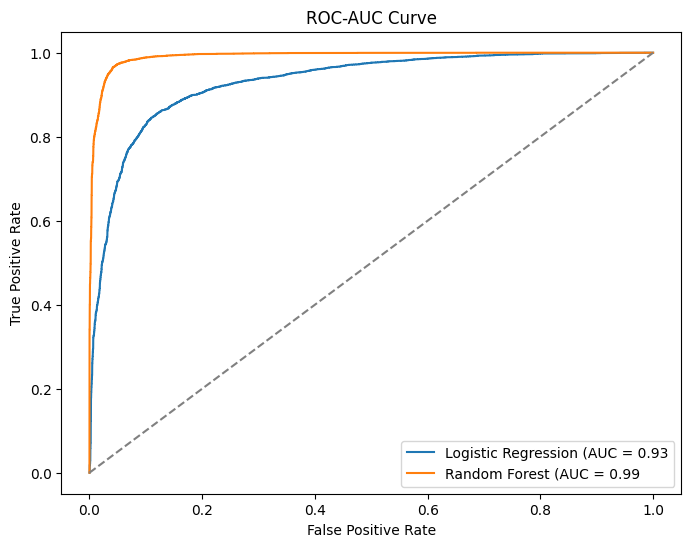

In [ ]:
# ROC-AUC Curve
plt.figure(figsize=(8, 6))
for model, label in zip([log_model, rf_model], ["Logistic Regression", "Random Forest"]):
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

<ipython-input-19-623099b2d936>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


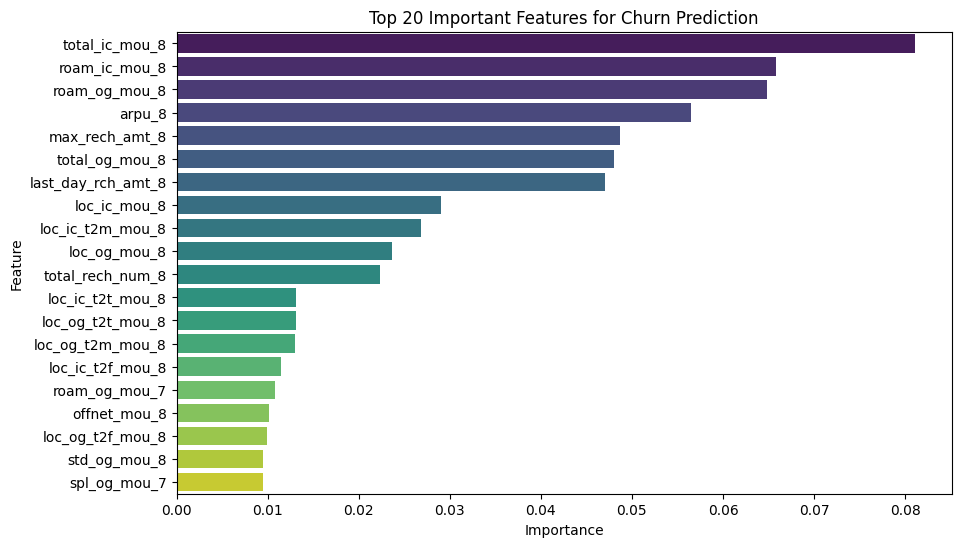

In [ ]:
# Feature Importance Analysis
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Top 20 Important Features for Churn Prediction")
plt.show()

In [ ]:
# Recommendations
print("\nBusiness Recommendations:")
print("1. Customers with low engagement should receive targeted retention offers.")
print("2. High-value customers with declining recharge amounts should be prioritized for engagement.")
print("3. Customers with high data usage but no recharge in recent months are at high risk of churn.")
print("4. The company can implement personalized discount plans to retain high-risk customers.")


Business Recommendations:
1. Customers with low engagement should receive targeted retention offers.
2. High-value customers with declining recharge amounts should be prioritized for engagement.
3. Customers with high data usage but no recharge in recent months are at high risk of churn.
4. The company can implement personalized discount plans to retain high-risk customers.
